# SNPs, alleles and site filters

This notebook looks in more detail at how single nucleotide polymorphisms (SNPs) are represented in the Ag1000G phase 3 (Ag3) data release. We'll also look at the different site filters that we've created to help select high quality SNPs for robust population genetic analyses. As always, this notebook is executable, click the launch icon (@@) and select a cloud computing service if you'd like to try running it for yourself.

## Setup

Before we get started, install some packages and set up access to the Ag3 data.

In [3]:
# TODO release new malariagen_data
!pip install -q -U --pre malariagen_data

In [4]:
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [43]:
from collections import Counter
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preamble: navigating the genome

In case this is the first time you're working with the *Anopheles gambiae* genome, here's a quick primer on how it's structured and how we refer to specific sites (locations) within the genome.

For Ag1000G analyses we use the AgamP4 reference genome. This genome is comprised of eight sequences:

In [6]:
genome = ag3.open_genome()
sorted(genome)

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

"2R" and "2L" are the two parts (arms) of Chromosome 2. "3R" and "3L" are the arms of Chromosome 3. "X" is the X chromosome. 

The X chromosome is a sex chromosome, present in two copies in females and one copy in males. Chromosomes 2 and 3 are autosomes, meaning that both males and females carry two copies. 

We typically only analyse data within these five sequences (2R, 2L, 3R, 3L, X). In case you're wondering, "UNKN" is a collection of sequences that couldn't be placed on a chromosome during the assembly process; "Y_unplaced" is a small collection of sequences known to belong to the male-specific Y chromosome; and "Mt" is the mitochondrial sequence.

Each of these sequences comprises a string of nucleotides. Here's how long they are:

In [7]:
for contig in genome:
    print(f"{contig}: {len(genome[contig]):,} bp")

2L: 49,364,325 bp
2R: 61,545,105 bp
3L: 41,963,435 bp
3R: 53,200,684 bp
Mt: 15,363 bp
UNKN: 42,389,979 bp
X: 24,393,108 bp
Y_unplaced: 237,045 bp


Here "bp" refers to base pairs, which is the unit of length of nucleotide sequences. If a sequence is 10 bp then it is 10 nucleotides (letters) long.

To refer to a specific site (position) within a sequence, we typically use 1-based coordinates. E.g., "2L:10" refers to the tenth nucleotide in the 2L sequence. We can access this nucleotide via Python, but when indexing in Python we need to use zero-based indices. E.g., access the nucleotide at position 10 on chromosome arm 2L:

In [8]:
genome["2L"][9]

b'c'

This nucleotide is a "c" (cytosine).

Note that there are gaps in the reference genome, where we don't know what the nucleotide is. These are represented in the genome sequence with the letter "N". Let's take a look at how common these are, for each chromosome arm: 

In [10]:
Counter(genome["2L"][:]).most_common()

[(b'T', 11398889),
 (b'A', 11394851),
 (b'C', 9348150),
 (b'G', 9341894),
 (b't', 2086607),
 (b'a', 2078364),
 (b'g', 1444984),
 (b'c', 1432008),
 (b'n', 838575),
 (b'N', 3)]

There are two things to notice here. First, there are both upper case and lower case letters. You can ignore this, e.g., both "T" and "t" mean the same thing. Second, there are 838,578 nucleotides which are unknown (either "N" or "n").

In [126]:
def plot_sequence_composition(contig, window_size=100_000, ax=None):
    
    # load reference genome sequence
    seq = genome[contig][:]
    
    # convert to upper-case
    seq = np.char.upper(seq)

    # locate nucleotides
    is_a = seq == b'A'
    is_c = seq == b'C'
    is_g = seq == b'G'
    is_t = seq == b'T'
    is_n = seq == b'N'
    is_other = ~is_a & ~is_c & ~is_g & ~is_t & ~is_n
    assert np.sum(is_other) == 0

    # construct bins
    bins = np.arange(0, len(seq), window_size)

    # count nucleotides
    h_a, _ = np.histogram(np.nonzero(is_a)[0], bins=bins)
    h_c, _ = np.histogram(np.nonzero(is_c)[0], bins=bins)
    h_g, _ = np.histogram(np.nonzero(is_g)[0], bins=bins)
    h_t, _ = np.histogram(np.nonzero(is_t)[0], bins=bins)
    h_n, _ = np.histogram(np.nonzero(is_n)[0], bins=bins)

    if ax is None:
        # plot size relative to largest contig
        figw = 12 * len(seq) / len(genome["2R"])
        fig, ax = plt.subplots(figsize=(figw, 1))
 
    palette = sns.color_palette('colorblind')
    colors = [palette[i] for i in [2, 0, 3, 8]] + ['k']

    # plot
    left = bins[:-1]
    bottom = 0
    width = np.diff(bins)
    for h, c, l in zip([h_a, h_t, h_g, h_c, h_n], colors, 'ATGCN'):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align='edge', label=l)
        bottom += h
        
    ax.set_xlim(0, len(seq))
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(['0%', '100%'])
    ax.set_xlabel("Position (Mbp)")
    ax.set_title(contig)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
    
    if contig in {'2L', '3L'}:
        ax.annotate("centromere", xy=(0, 1), xycoords="axes fraction", 
                    xytext=(0, 2), textcoords='offset points', va='bottom', ha='left')
        ax.annotate("telomere", xy=(1, 1), xycoords="axes fraction", 
                    xytext=(0, 2), textcoords='offset points', va='bottom', ha='right')
    else:
        ax.annotate("telomere", xy=(0, 1), xycoords="axes fraction", 
                    xytext=(0, 2), textcoords='offset points', va='bottom', ha='left')
        ax.annotate("centromere", xy=(1, 1), xycoords="axes fraction", 
                    xytext=(0, 2), textcoords='offset points', va='bottom', ha='right')
    
    # legend
    ax.legend(loc='center left', bbox_to_anchor=(1, .5), 
              prop=dict(family='monospace'), ncol=2,
              frameon=False)
        

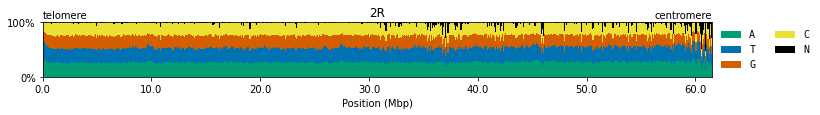

In [127]:
plot_sequence_composition('2R')

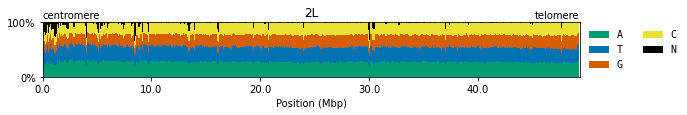

In [128]:
plot_sequence_composition('2L')

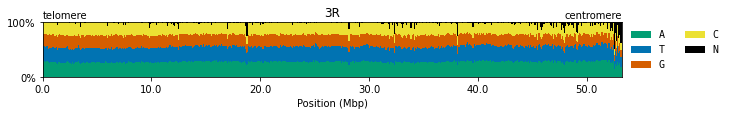

In [129]:
plot_sequence_composition('3R')

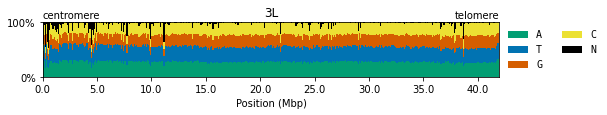

In [130]:
plot_sequence_composition('3L')

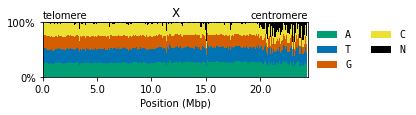

In [131]:
plot_sequence_composition('X')

In the above plots I converted the genomic position coordinates to "Mbp" which means mega-base pairs, i.e., millions of letters.

I also made the size of the figure proportional to the size of the sequence. This can help get a feeling for the relative size of the different sequences.

## SNP sites and alleles

When studying genetic variation in natural populations, there are two fundamental questions:

1. Where in the genome do we observe **differences (i.e., nucleotide variation)** between individual mosquitoes. 

2. Where in the genome do we observe **no differences (i.e., nucleotide conservation)** between individuals. 

Sometimes this second question is overlooked, but both questions are important.

In Ag1000G phase 3 we have taken a slightly different approach to calling single nucleotide polymorphisms (SNPs - single letter differences) than in previous project phases. Because we are interested in both of the above questions, we have genotyped all individual mosquitoes at all genomic sites where the reference genotype nucleotide is known (i.e., not an "N"). This is sometimes known as an "all sites" analysis. 

In order to simplify SNP calling across a large number of individuals, we also predefined the set of all possible alternate (variant) SNP alleles. Because we are analysing SNPs, at each site in the genome there are three possible alternate alleles. Let's look at how these data are represented for chromosome arm 2L:

In [133]:
pos, ref, alt = ag3.snp_sites(contig="2L")

The `pos` array here holds the 1-based positions (coordinates) where the SNPs were called. E.g., here's the first 10 positions:

In [134]:
pos[:10].compute()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

Note that this is simply the numbers 1-10. However, this sequence does not continue increasing by 1 all the way through the array, i.e., there are gaps, because of gaps in the reference genome. We can quickly visualise that:

In [135]:
p = pos.compute()
d = np.diff(p)

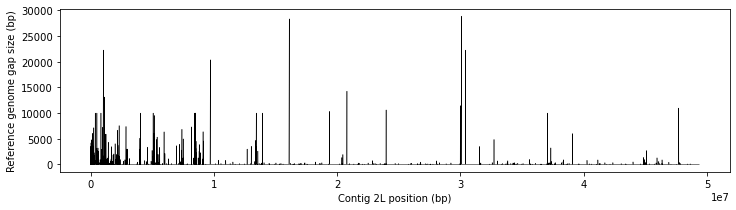

In [137]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p[1:], d, color='black', linewidth=.5)
ax.set_xlabel('Contig 2L position (bp)')
ax.set_ylabel('Reference genome gap size (bp)');

Note also that the length of the `pos` array is less than the length of the reference genome sequence:

In [33]:
len(genome["2L"]) - len(pos)

838578

This difference is the number of unknown nucleotides ("N"s) in the reference genome. This is another way of confirming that we have called SNP genotypes at all genomic sites where the reference genome nucleotide is known.

The `ref` array holds the reference alleles, i.e., the reference genome nucleotide for each SNP site. E.g., here's the reference alleles at the first 10 SNP sites:

In [34]:
ref[:10].compute()

array([b'A', b'A', b'C', b'C', b'A', b'T', b'G', b'G', b'T', b'C'],
      dtype='|S1')

The `alt` array holds the predefined alternate alleles at each site. E.g., here's the alternate alleles for the first 10 SNP sites:

In [35]:
alt[:10].compute()

array([[b'C', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'T', b'G'],
       [b'A', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'C', b'G'],
       [b'A', b'C', b'T'],
       [b'A', b'C', b'T'],
       [b'A', b'C', b'G'],
       [b'A', b'T', b'G']], dtype='|S1')

Each row represents a site, and the columns show the three alternate alleles.

@@TODO something about allele indices, and how genotypes are represented.